In [11]:
# Add path
import sys
sys.path.insert(1, '../Scripts')

# Packages for Our filters
import measfilter as mf # package for measurement error filter
import gatesimu as gs # package for gate and measurment error filter

from qiskit import IBMQ, QuantumRegister, transpile, execute
# Package for Qiskit error filter
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)

# Package for other Qiskit functions
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram


# Needed for functions
import numpy as np
import matplotlib.pyplot as plt

# Tutorial

## Section 1: Measurmenet Error
### Create filter for measurment error

First, we choose a backend to operate.

In [2]:
# Load Account and Choose Backend
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
name = 'ibmqx2' # ibmq_16_melbourne, ibmq_vigo, ibmq_london, ibmq_burlington, ibmq_essex, ibmqx2, ibmq_ourense
backend = provider.get_backend(name) 

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


We plan to run Grover's search whose solution is 11. So we first look at which quibits we will need to get information. The circuit will run on Qubit 0, 1, and 2. But the measurment operation is only on Qubit 1 and 2.

In [3]:
interested_qubits = [2,1] # Descending order because Qiskit's readout is little-endian

Now we collect data for our filter. Here we make `if_write=True` so that we can save the data and re-create the filter anytime we want. But no matter if `if_write=True` or not, a file that records backend proporties will be generated under `file_address`. if `file_address` is an empty string, the data will be saved where the script runs, otherwise `file_address` need to end with `/`.

By default, `itr * shots / 1024` number of data points will be used for Bayesian inference latter. `32 * 8192` usually takes a few minutes.

In [5]:
itr = 32
shots = 8192
file_address = ''
readout = mf.collect_filter_data(backend, itr=itr,shots=shots,if_monitor_job=True,if_write=True,file_address=file_address)

Job Status: job has successfully run


Collect data for the measurement error filter in Qiskit. So we can do a comparison at the end.

In [12]:
qr = QuantumRegister(len(interested_qubits))
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
for i in range(len(meas_calibs)):
    meas_calibs[i] = transpile(meas_calibs[i],backend,initial_layout=interested_qubits)

job = execute(meas_calibs, backend=backend,shots=8192,optimization_level=0)
job_monitor(job)

cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results,state_labels,circlabel='mcal')
meas_filter = meas_fitter.filter

Job Status: job has successfully run


Then we can create our filter and run `inference()` to inference the data. If  `inference()` is run once, `post_from_file()` can directly read previous posteriors.

In [16]:
Cons_filter = mf.MeasFilter(interested_qubits, file_address=file_address)
# BJW_filter.inference(nPrior=40000, Priod_sd=0.1, seed=127, shots_per_point=1024)
Cons_filter.post_from_file() # if inference() is already run once

In [17]:
Cons_filter.mean()

{'Qubit2': array([0.93783025, 0.91442647]),
 'Qubit1': array([0.93658071, 0.90995038])}

In [18]:
Cons_filter.mode()

{'Qubit2': array([0.96526854, 0.93027125]),
 'Qubit1': array([0.96223865, 0.92265612])}

### Grover's search Experiment

Run provided Grover's search experiment, the counts will be written to `Count_Grover.csv`. Then we read the data back.

In [20]:
from expfuncs import Groverexp
Groverexp(backend, file_address=file_address)

Grover circuit depth is  39
Job Status: job has successfully run


In [22]:
# Read Grover data
import csv
with open(file_address + 'Count_Grover.csv', mode='r') as sgm:
    reader = csv.reader(sgm)
    temp_counts = {}
    for row in reader:   
        temp_counts[row[0]] = int(row[1])
real_counts = {}
for key in temp_counts.keys():
    real_counts[key[0:2]] = temp_counts[key] # we only measurmeent last two qubits, so slice the keys

In [23]:
qis_counts = meas_filter.apply(real_counts)
mean_counts = Cons_filter.filter_mean(real_counts)
mode_counts = Cons_filter.filter_mode(real_counts)

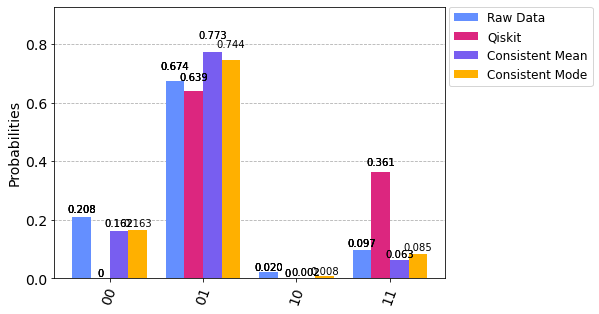

In [24]:
legend = ['Raw Data', 'Qiskit', 'Consistent Mean', 'Consistent Mode']
plot_histogram([real_counts, qis_counts, mean_counts, mode_counts], legend=legend)

## Section 2: Gate and Measurmenet Error

In [ ]:
interested_qubits = [4,3]
gate_num = 100
gate_type = 'X'

# Collect U3-Gate Data
for q in interested_qubits:
    gs.Gateexp(gate_num, gate_type, q, itr, backend, file_address =file_address)

In [ ]:
# Read data back
with open(file_address + 'Readout_{}{}Q{}.csv'.format(gate_num, gate_type, interested_qubits[1]), mode='r') as measfile:
    reader = csv.reader(measfile)    
    data1 = np.asarray([row for row in reader][0])
with open(file_address + 'Readout_{}{}Q{}.csv'.format(gate_num, gate_type, interested_qubits[0]), mode='r') as measfile:
    reader = csv.reader(measfile) 
    data2 = np.asarray([row for row in reader][0])

In [ ]:
gs_filter = gs.GMFilter(interested_qubits,gate_num, gate_type, device_param_address=file_address, data_file_address=file_address)
# gs_filter.inference(nPrior=40000, meas_sd=0.1, gate_sd=0.01, seed=127, shots_per_point=1024)
gs_filter.post_from_file()

In [ ]:
# Read data back
with open(file_address + 'Readout_{}{}Q{}.csv'.format(gate_num, gate_type, interested_qubits[1]), mode='r') as measfile:
    reader = csv.reader(measfile)    
    data1 = np.asarray([row for row in reader][0])
with open(file_address + 'Readout_{}{}Q{}.csv'.format(gate_num, gate_type, interested_qubits[0]), mode='r') as measfile:
    reader = csv.reader(measfile) 
    data2 = np.asarray([row for row in reader][0])
    
p0s1 = mf.getData0(data1, 128, interested_qubits[1])
p0s2 = mf.getData0(data2, 128, interested_qubits[0])

In [ ]:
Q1BJW = gs_filter.filter_mean(p0s1, interested_qubits[1])
Q2BJW = gs_filter.filter_mean(p0s2, interested_qubits[0])

In [ ]:
plt.hist(Q1BJW, label = 'Qubit{}'.format(interested_qubits[1]))
plt.xlabel('Probability of measuring 0')
plt.ylabel('Counts')
plt.legend()
plt.show()
plt.hist(Q2BJW, label = 'Qubit{}'.format(interested_qubits[0]))
plt.xlabel('Probability of measuring 0')
plt.ylabel('Counts')
plt.legend()
plt.show()